Saving children-born-per-woman.csv to children-born-per-woman.csv
Saving female-labor-force-participation-oecd.csv to female-labor-force-participation-oecd.csv
Saving marriage-rate-per-1000-inhabitants.csv to marriage-rate-per-1000-inhabitants.csv
Saving mean-years-of-schooling-female.csv to mean-years-of-schooling-female.csv
Saving period-average-age-of-mothers-birth-order.csv to period-average-age-of-mothers-birth-order.csv
Labor cols: ['Entity', 'Code', 'Year', 'Female labor force participation rate (OWID based on OECD 2017 and others)']
Marriage cols: ['Entity', 'Code', 'Year', 'Crude marriage rate (marriages per 1,000 people)']
Fertility cols: ['Entity', 'Code', 'Year', 'Fertility rate (period), historical']
Schooling cols: ['Entity', 'Code', 'Year', 'Mean years of schooling (ISCED 1 or higher), population 25+ years, female']
BirthAge cols: ['Entity', 'Code', 'Year', 'Period mean ages at birth - Birth order: 1', 'Period mean ages at birth - Birth order: 2', 'Period mean ages at bi

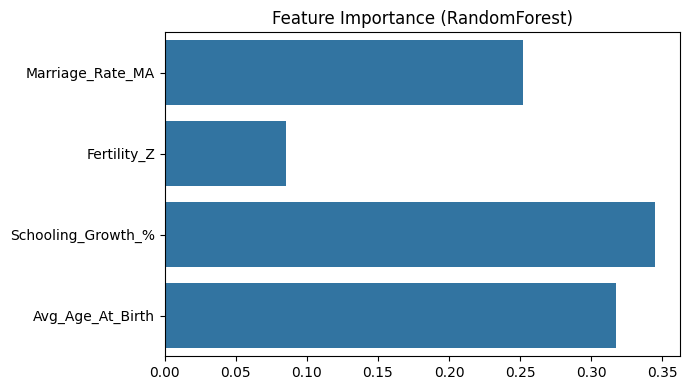

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from google.colab import files


uploaded = files.upload()

labor    = pd.read_csv("female-labor-force-participation-oecd.csv")
marriage = pd.read_csv("marriage-rate-per-1000-inhabitants.csv")
fertility= pd.read_csv("children-born-per-woman.csv")
schooling= pd.read_csv("mean-years-of-schooling-female.csv")
birth_age= pd.read_csv("period-average-age-of-mothers-birth-order.csv")


print("Labor cols:",    labor.columns.tolist())
print("Marriage cols:", marriage.columns.tolist())
print("Fertility cols:",fertility.columns.tolist())
print("Schooling cols:",schooling.columns.tolist())
print("BirthAge cols:", birth_age.columns.tolist())

# filter only US data and rename column for clarity
def filter_us(df, col_name, new_name):
    return (
      df[df['Entity']=="United States"]       # Filter only US rows
        [['Year', col_name]]                  # Keep only Year and the selected column
        .rename(columns={col_name:new_name})  # Rename the selected column to a clean label
    )

# Apply filter_us to each dataset; dynamically detect schooling column
school_col = [c for c in schooling.columns if 'schooling' in c.lower()][0]  # Flexibly locate schooling column

# Apply filter + rename for each dataset
labor_us    = filter_us(labor,    'Female labor force participation rate (OWID based on OECD 2017 and others)', 'Labor_Force_Participation')
marriage_us = filter_us(marriage, 'Crude marriage rate (marriages per 1,000 people)', 'Marriage_Rate')
fertility_us= filter_us(fertility,'Fertility rate (period), historical',   'Fertility_Rate')
schooling_us= filter_us(schooling, school_col,                            'Schooling_Years')
birthage_us = filter_us(birth_age, 'Period mean ages at birth - Total',   'Avg_Age_At_Birth')

# Merge all datasets on Year
df = (labor_us
      .merge(marriage_us, on='Year')
      .merge(fertility_us, on='Year')
      .merge(schooling_us, on='Year')
      .merge(birthage_us, on='Year'))

# Feature Engineering:
df['Marriage_Rate_MA']    = df['Marriage_Rate'].rolling(3, min_periods=1).mean()  # Smooth marriage rate with 3-year moving average
df['Fertility_Z']         = (df['Fertility_Rate'] - df['Fertility_Rate'].mean()) / df['Fertility_Rate'].std()  # Standardize fertility
df['Schooling_Growth_%']  = 100*(df['Schooling_Years'] - df['Schooling_Years'].iloc[0]) / df['Schooling_Years'].iloc[0]  # % growth in schooling
df.dropna(inplace=True)  # Drop rows with missing values to avoid model errors

# Prepare features (X) and target (y), scale them, and split
features = ['Marriage_Rate_MA','Fertility_Z','Schooling_Growth_%','Avg_Age_At_Birth']
X = df[features]
y = df['Labor_Force_Participation']

scaler = StandardScaler()            # Standardize features to zero mean and unit variance
Xs = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=42)

# Hyperparameter tuning & evaluation using GridSearchCV

models = {
  'RandomForest': (
      RandomForestRegressor(random_state=42),
      {'n_estimators':[100,200],'max_depth':[None,5,10]}  # Trees and depth tuning
  ),
  'SVR': (
      SVR(),
      {'kernel':['rbf','linear'],'C':[0.1,1,10],'epsilon':[0.01,0.1,0.5]}  # SVR tuning grid
  )
}

# Evaluation function to print performance metrics
def evaluate(name, y_true, y_pred):
    r2  = r2_score(y_true,y_pred)                  # R^2: goodness of fit
    mae = mean_absolute_error(y_true,y_pred)       # MAE: average absolute error
    mse = mean_squared_error(y_true,y_pred)        # MSE: penalizes large errors
    print(f"\n{name}: R²={r2:.3f}, MAE={mae:.2f}, MSE={mse:.2f}")

# Train and evaluate each model using grid search
for name,(model,params) in models.items():
    print(f"\n🔍 Tuning {name} …")
    grid = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)  # Cross-validated grid search on R²
    grid.fit(X_train, y_train)
    preds = grid.predict(X_test)                                       # Predict on test data
    print(" Best params:", grid.best_params_)
    evaluate(name+" (Optimized)", y_test, preds)

# Interpretability: Feature importance from best Random Forest
best_rf = GridSearchCV(RandomForestRegressor(random_state=42),
                       {'n_estimators':[100,200],'max_depth':[None,5,10]},
                       cv=3, scoring='r2').fit(X_train,y_train).best_estimator_

imp = best_rf.feature_importances_   # Extract importance scores

# Visualize feature importances
plt.figure(figsize=(7,4))
sns.barplot(x=imp, y=features)
plt.title("Feature Importance (RandomForest)")
plt.tight_layout()
plt.show()
